<a href="https://colab.research.google.com/github/Ardaolmez/Neuroscience-Projects/blob/main/Surrogate_Techniques.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Exercise: Spike Analysis, Part 2

## Continued from Part 1

In the previous tasks we implemented the following functions:

In [3]:
import random

import numpy as np
import matplotlib.pyplot as plt
#% matplotlib

# ===== functions from the previous tasks =====
def dotdisplay(spikes):
    for i, spk in enumerate(spikes):
        x = spk
        y = np.ones_like(x) * i
        plt.plot(x, y, 'k|')

def segment_spike_train(ts_spk, trig, t_pre, t_post):
    '''
    Segment a given spike train around a given set of trigger times.

    Arguments
    ---------
    ts_spk : a list or array containing spike times
    trig : a list or array containing trigger times for segmentation
    t_pre : start time of a segment relative to trigger time
    t_post : end time of a segment relative to trigger time

    Returns
    -------
    segments : a list containing segments of the spike train segmented
               around the trigger times
    '''
    segments = []

    for t_trig in trig:
        segments.append(ts_spk[(t_trig + t_pre < ts_spk) & (ts_spk < t_trig + t_post)] - t_trig)

    return segments

def bin_spike_train(spk, bin_width, bin_step, t_start, t_stop):
    '''
    bin a given spike train with given binning paramters

    Arguments
    ---------
    spk : an array containing spike times
    bin_width : temporal width of a bin
    bin_step : interval between neighboring bins
    t_start, t_stop: starting and stopping time points of binning

    Returns
    -------
    spike_counts : an array containing spike counts of each bin
    bin_pos : temporal positions of (the center of) bins
    '''
    # define bins
    bin_left = np.arange(t_start, t_stop - bin_width, bin_step)
    bin_right = bin_left + bin_width
    num_bin = bin_left.size

    # count spikes that fall within each bin
    spike_counts = np.empty(num_bin)
    for i in range(num_bin):
        spike_counts[i] = spk[(bin_left[i] < spk) & (spk < bin_right[i])].size

    bin_pos = bin_left + bin_width / 2

    return spike_counts, bin_pos

def comp_psth(spikes, trig, bin_width, bin_step, t_start, t_stop):
    # segment spike trains
    spikes_trial = segment_spike_train(spikes, trig, t_start, t_stop)

    # bin eash spike train segment
    spike_count_buff = []
    for spk in spikes_trial:
        spike_counts, bin_pos = bin_spike_train(spk, bin_width, bin_step, t_start, t_stop)
        spike_count_buff.append(spike_counts)

    # compute PSTH
    psth = np.mean(spike_count_buff, axis=0) / bin_width

    return psth, bin_pos


# load data
spikes = np.load("/content/spikes.npy", encoding='bytes', allow_pickle=True)
stim_on = np.load("/content/stim_on.npy", encoding='bytes', allow_pickle=True)

<ipython-input-3-87d1c52e939c>:84: UserWarning: Reading `.npy` or `.npz` file required additional header parsing as it was created on Python 2. Save the file again to speed up loading and avoid this warning.
  spikes = np.load("/content/spikes.npy", encoding='bytes', allow_pickle=True)
<ipython-input-3-87d1c52e939c>:85: UserWarning: Reading `.npy` or `.npz` file required additional header parsing as it was created on Python 2. Save the file again to speed up loading and avoid this warning.
  stim_on = np.load("/content/stim_on.npy", encoding='bytes', allow_pickle=True)


## **Task 3**: Cross-correúlation histogram

Cross-correlation histogram (CCH) is a technique to visualize and quantify temporal relations between two spike trains.
It is defined as *the histogram of spike times of one spike train relative to the spike times of the other*.
This means that ** CCH is essentially a PSTH of one spike train triggered by the spike times of the other spike train**.
Consequently, for computation of CCH, you can just use the same functions as you used for the PSTH computation in the previous tasks.

Give two spike trains as the first two arguments of the function `segment_spike_train()`, then you get spike train segments cut out from the first spike train around the spike times in the second spike train (i.e., you used the spike times of the second spike train to trigger the segmentation of the first spike train).
Given such segmenteds, CCH can be obtained by applying the binning function `bin_spike_train()` to the segments and taking the mean of the spike counts over the segments in a bin-wise manner, just as you did for PSTH.

The binning parameters that you give to the function `bin_spike_train()` needs to be chosen carefully. You should keep in mind the following things:

* The bin width should be set to the temporal resolution of the spike recording, in our case 0.001 sec.
* The bin step should also be identical to the bin width.
* The starting and stopping time points of binning should be carefully chosen to avoid spike times aligned on bin borders.
    * In concrete, `t_start` and `t_stop` should NOT be a multiple of the bin width, but need to be shifted from the multiples (e.g. by a half of the bin width).

* **Task 3a**: compute the CCH between the spike trains of units 1 and 10 for time lags from -0.3 s to 0.3 s, using the functions that you implemented in the previous task for computation of PSTH, i.e., `segment_spike_train()`, `bin_spike_train()` and `comp_psth()`. (1 point)

10


Text(0.5, 0.98, 'Cross-correlation histogram: unit 1 and unit 10')

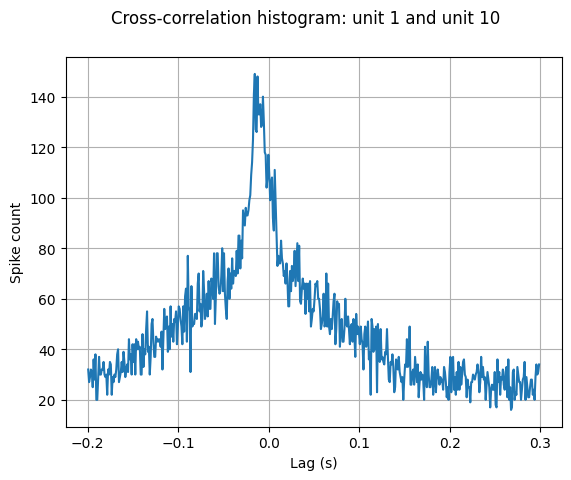

In [4]:
# set appropriate parameter values
bin_width = 0.001
bin_step = 0.001
t_start = -0.2
t_stop = 0.3

unitIDs = (1, 10)
print(unitIDs[1])

# compute the cross-correlation histogram as PSTH
cch_as_psth, bin_pos = comp_psth(spikes[unitIDs[0]],spikes[unitIDs[1]] , bin_width, bin_step, t_start, t_stop)    # give appropriate arguments
cch_as_psth = cch_as_psth * bin_width * len(spikes[unitIDs[1]])   # conversion from firing rate to spike count

# plot the result
plt.plot(bin_pos, cch_as_psth)
plt.grid()
plt.xlabel("Lag (s)")
plt.ylabel("Spike count")
plt.suptitle("Cross-correlation histogram: unit {0} and unit {1}".format(*unitIDs))

As its name indicates, CCH can also be calculated by directly cross-correlating two spike trains.
You can use a NumPy built-in function for cross-correlation calculation, i.e., **numpy.correlate()**, which returns the cross-correlation between two time series for all possible lags (i.e., the length of the time series).
Note that this function does not accept a spike train (a list of time stamps) as its input, but requires a *time series*.
This means that you need to apply a binning to the spike trains to represent them as time series.

* **Task 3b**: complete the function `correlate_spike_trains()` below, which computes CCH of a pair of spike trains using **numpy.correlate()**. (1 point)

In [8]:
import numpy as np

def correlate_spike_trains(spk0, spk1, bin_width, lag_max):
    """
    Compute cross-correlation of two spike trains up to the given maximum lag.

    Arguments
    ---------
    spk0, spk1 : arrays containing spike times
    bin_width : width of binning
    lag_max : maximum lag, up to which the spike trains are correlated

    Returns
    -------
    corr : an array containing correlation coefficients across lags from -lag_max to lag_max
    lags : an array containing lag values
    """

    # Set the starting and stopping time points of binning according to the
    # first and the last spike times in the given spike trains
    t_spk_first = np.min(np.concatenate((spk0, spk1)))
    t_spk_last = np.max(np.concatenate((spk0, spk1)))
    t_start = t_spk_first - bin_width / 2
    t_stop = t_spk_last + bin_width / 2

    # Bin the spike trains
    bins = np.arange(t_start, t_stop, bin_width)
    spk0_binned, _ = np.histogram(spk0, bins)
    spk1_binned, _ = np.histogram(spk1, bins)

    # Compute CCH using numpy.correlate
    corr_all = np.correlate(spk0_binned, spk1_binned, mode='full')

    # Define the range of lags
    lags = np.arange(-len(spk0_binned) + 1, len(spk1_binned)) * bin_width

    # Return a slice of the obtained CCH corresponding to the lags
    idx_ini = len(lags) // 2 - int(lag_max / bin_width)
    idx_fin = len(lags) // 2 + int(lag_max / bin_width) + 1
    corr = corr_all[idx_ini:idx_fin]
    lags = lags[idx_ini:idx_fin]

    return corr, lags




* **Task 3c**: compute the CCH between the spike trains of units 1 and 10 using the function `correlate_spike_trains()`. Use the same parameter values as used in **Task 3a**, and plot the obtained CCH together with the result of **Task 3a** in one plot, to confirm that they are identical. (0.5 point)

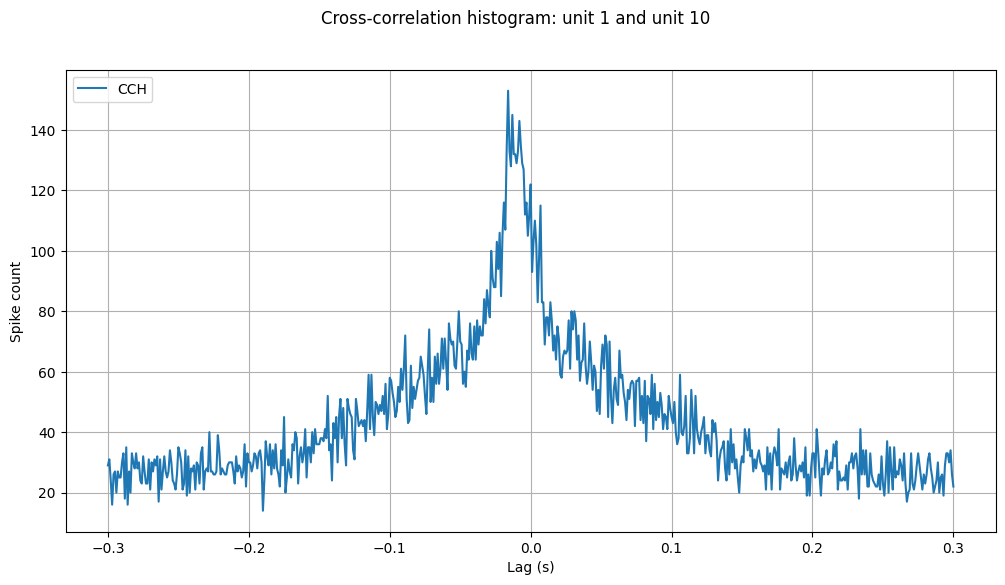

In [9]:
# Set appropriate parameter values
bin_width = 0.001
lag_max = 0.3

unitIDs = (1, 10)

# Compute CCH using numpy.correlate() as the backend
cch_numpy, lags = correlate_spike_trains(spikes[1], spikes[10], bin_width, lag_max)

# Plot the result
plt.figure(figsize=(12, 6))
plt.plot(lags, cch_numpy, label="CCH")
plt.grid()
plt.xlabel("Lag (s)")
plt.ylabel("Spike count")
plt.legend(loc='upper left')
plt.suptitle("Cross-correlation histogram: unit {0} and unit {1}".format(unitIDs[0], unitIDs[1]))
plt.show()


## Task 4: Significance Test

A high CCH value does not necessarily mean *significant* correlation between two spike trains.
To draw a conclusion about correlation, you need to apply a significance test to the CCH.
In this task you learn how to perform significance tests on CCHs by use of surrogate methods.
The basic procedure of a significance test using surrogates is as follows:

1.	Generate a large number of surrogate data by randomizing the original data in a specific manner, which destroys a certain aspect of correlations in the original data.
2.	Compute CCH from each of the surrogate data to estimate the *distribution* of CCH values expected from random data.
3.	Based on the obtained distribution, derive the p-value of the CCH computed from the original data. If this p-value exceeds a certain significance level (typically below 5 %), the original CCH values are considered to be significantly deviated from the expectation by chance.

There are several ways to generate surrogate data from the original, depending on which features of the original data you want to preserve or destroy.
In this exercise we consider three methods: **trial shufflling**, **spike randomization**, and **spike dithering**.

### Trial shuffle surrogate

This surrogate is generated by first segmenting the original spike train into trials, then randomizing the order of the segments, and lastly concatenating the segments back into a single spike train.

* **Task 4a**: complete the function `trial_shuffle()` below. Generate a trial shuffle surrogate of the spike train of unit 0, and draw dot displays of the original and surrogate spike trains. (1 point)
    * Note that, when you generate surrogate data using the function `trial_shuffle()`, you need to give to the function an array that contains the onset times of *all* stimulus types. Below is a sample code to generate such an array:


	stim_on_all = np.array([])
	for ts_on in stim_on:
		stim_on_all = np.append(stim_on_all, ts_on)
	stim_on_all.sort()

Text(0, 0.5, 'Trial')

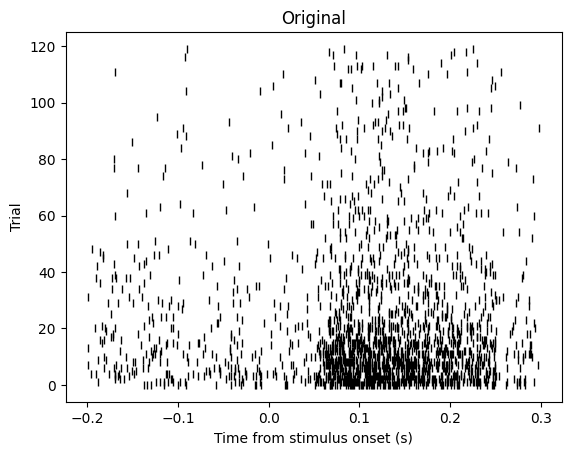

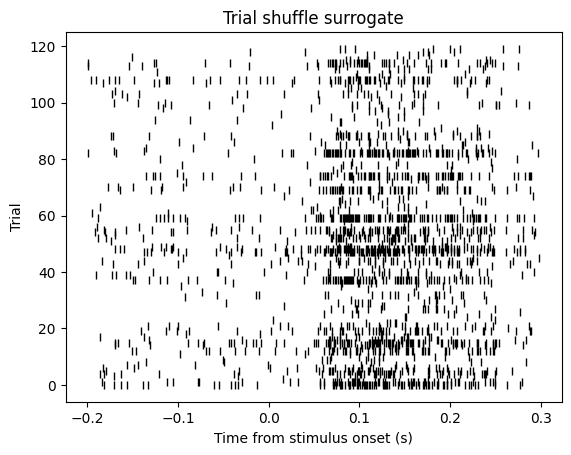

In [12]:
def trial_shuffle(spk, trig, t_pre, t_post):
    # segment the spike train into trials
    spikes_trial = segment_spike_train(spk, trig, t_pre, t_post)    # give appropriate arguments

    # shuffle the segments
    # !!!!!!!!!!!!!!!!!!!!!!!
    #    TO BE IMPLEMENTED
    # !!!!!!!!!!!!!!!!!!!!!!!
    # randomly shuffle the elements of `spikes_trial` using the function `random.shuffle()`
    np.random.shuffle(spikes_trial)

    # concatenate the shuffled trials back into a sigle spike train
    spikes_shuffled = np.array([])
    for i, ts_spk in enumerate(spikes_trial):
        # `ts_spk` are spike times relative to the stimulus onset.
        # Here, add the corresponding stimulus onset time to `ts_spk`
        # so that it's back in the original time frame
        ts_spk_concat = ts_spk + trig[i]
        spikes_shuffled = np.append(spikes_shuffled, ts_spk_concat)

    return spikes_shuffled


# set parameter values
t_pre = -0.2
t_post = 0.3

# concatenate onset times of all stimulus types (and sort them)
stim_on_all = np.array([])
for ts_on in stim_on:
    stim_on_all = np.append(stim_on_all, ts_on)
stim_on_all.sort()

# generate surrogate spike train
spikes0 = spikes[0]
spikes0_TSsrgt = trial_shuffle(spikes0,stim_on_all,t_pre,t_post)    # give appropriate arguments

# draw dot displays of the original and surrogate spike trains
plt.figure(1)
plt.title("Original")
dotdisplay(segment_spike_train(spikes0,stim_on_all,t_pre,t_post))    # give appropriate arguments
plt.xlabel("Time from stimulus onset (s)")
plt.ylabel("Trial")

plt.figure(2)
plt.title("Trial shuffle surrogate")
dotdisplay(segment_spike_train(spikes0_TSsrgt,stim_on_all,t_pre,t_post))    # give appropriate arguments
plt.xlabel("Time from stimulus onset (s)")
plt.ylabel("Trial")

### Spike randomize surrogate

This surrogate is generated by randomizing the timing of each and every spike in the original spike train.

* **Task 4b**: complete the function `spike_randomize()` below. Generate a spike randomize surrogate of the spike train of unit 0, and draw dot displays of the original and surrogate spike trains. (1 point)

Text(0.5, 1.0, 'Spike randomize surrogate')

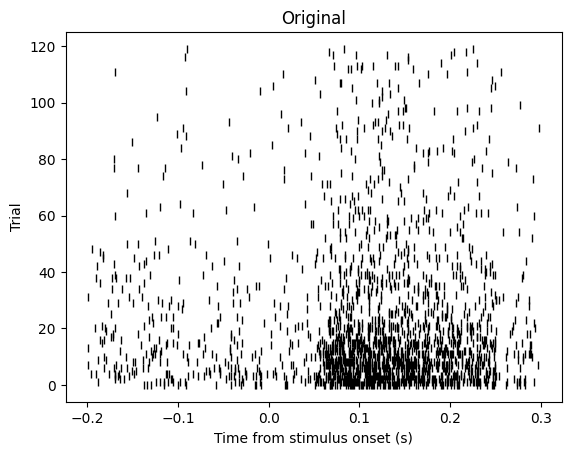

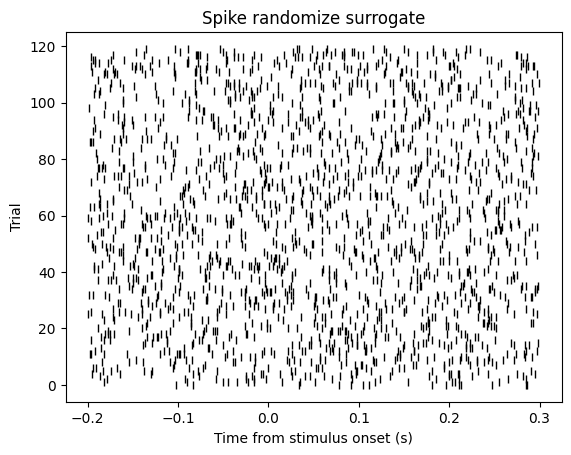

In [15]:
def spike_randomize(spikes, bin_width):
    # set the starting and stopping time points of binning according to the
    # first and the last spike times in the given spike trains
    t_spk_first = spikes[0]    # identify the first spike time
    t_start = t_spk_first-bin_width/2    # define t_start as `t_spk_first` shifted by the half of the bin width
    t_spk_last = spikes[-1]    # identify the last spike time
    t_stop = t_spk_last+ bin_width/2    # define t_stop as `t_spk_last` shifted by the half of the bin width


    spike_counts,bins=bin_spike_train(spikes, bin_width, 0.001, t_start, t_stop)
    # shuffle the spike counts across bins
    random.shuffle(spike_counts)
    # convert the shuffled spike counts back into a spike train
    arg_spikes = np.where(spike_counts > 0)[0]
    return arg_spikes * bin_width + t_start


# set appropriate parameter values
t_pre = -0.2
t_post = 0.3
bin_width = 0.001

# generate surrogate spike train
spikes0 = spikes[0]
spikes0_SRsrgt = spike_randomize(spikes[0],bin_width)

# draw dot displays of the original and surrogate spike trains
plt.figure(1)
dotdisplay(segment_spike_train(spikes0,stim_on_all,t_pre,t_post))
plt.xlabel("Time from stimulus onset (s)")
plt.ylabel("Trial")
plt.title("Original")

plt.figure(2)
dotdisplay(segment_spike_train(spikes0_SRsrgt,stim_on_all,t_pre,t_post))
plt.xlabel("Time from stimulus onset (s)")
plt.ylabel("Trial")
plt.title("Spike randomize surrogate")

### Spike dither surrogate

This surrogate is generated by dithering (= slightly and randomly shifting the spike time of) each and every spike in the original spike train within an pre-defined dither width.

* **Task 4c**: complete the function `spike_dither()` below. Generate a spike dither (use dither width of 0.020 sec for the spike dither surrogate) surrogate of the spike train of unit 0, and draw dot displays of the original and surrogate spike trains. (1 point)

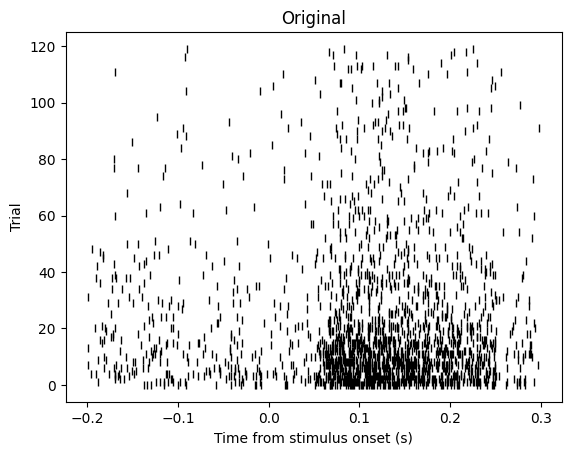

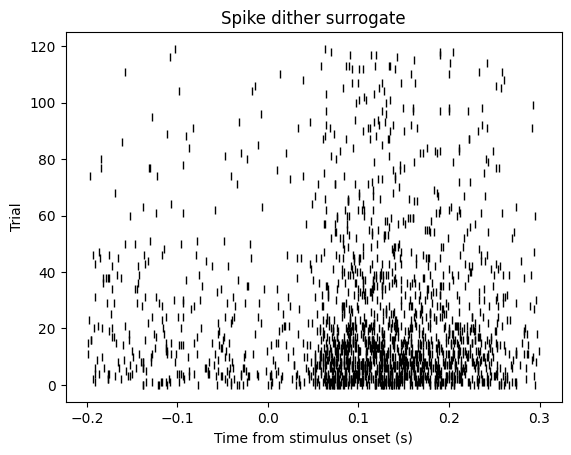

In [20]:
import numpy as np

def spike_dither(spikes, bin_width, dither_width):
    """
    Generate a spike dither (surrogate) by slightly and randomly shifting the spike time of each spike within a pre-defined dither width.

    Arguments
    ---------
    spikes : array containing spike times
    bin_width : width of binning
    dither_width : maximum dither width

    Returns
    -------
    dithered_spikes : array containing dithered spike times
    """
    # Set the starting and stopping time points of binning according to the first and the last spike times in the given spike trains
    t_spk_first = spikes[0]
    t_start = t_spk_first - bin_width / 2
    t_spk_last = spikes[-1]
    t_stop = t_spk_last + bin_width / 2

    # Bin the spike trains
    bins = np.arange(t_start, t_stop, bin_width)
    spike_counts, _ = np.histogram(spikes, bins)

    # Dither each spike within the given range
    max_dither = int(dither_width / bin_width)
    spike_counts_dithered = np.zeros_like(spike_counts, dtype=int)

    for i, spkcnt in enumerate(spike_counts):
        if spkcnt > 0:
            i_dithered = np.clip(i + np.random.randint(-max_dither, max_dither + 1), 0, len(spike_counts) - 1)
            spike_counts_dithered[i_dithered] += spkcnt

    # Convert the dithered spike counts back into spike times
    dithered_spikes = []
    for i, count in enumerate(spike_counts_dithered):
        dithered_spikes.extend([bins[i]] * count)

    return np.array(dithered_spikes)


# Set parameter values
t_pre = -0.2
t_post = 0.3
bin_width = 0.001
dither_width = 0.02

# Generate surrogate spike train
spikes0 = spikes[0]
spikes0_SDsrgt = spike_dither(spikes0, bin_width, dither_width)

# Draw dot displays of the original and surrogate spike trains
plt.figure(1)
plt.title("Original")
dotdisplay(segment_spike_train(spikes0, stim_on_all, t_pre, t_post))
plt.xlabel("Time from stimulus onset (s)")
plt.ylabel("Trial")

plt.figure(2)
plt.title("Spike dither surrogate")
dotdisplay(segment_spike_train(spikes0_SDsrgt, stim_on_all, t_pre, t_post))
plt.xlabel("Time from stimulus onset (s)")
plt.ylabel("Trial")

plt.show()


* **Task 4d**: Generate the above 3 types of surrogates from the spike train of unit 1 (use **a dither width of 0.020 sec** for the spike dither surrogate). Then, for each surrogate type, compute the CCH between the surrogate spike train of unit 1 and the original (not surrogate!) spike train of unit 10. Plot the obtained CCHs on the same axes, together with the original CCH (i.e., what you computed in **Task 3**). Which surrogate type preserves best the shape of the original CCH? (1 point)

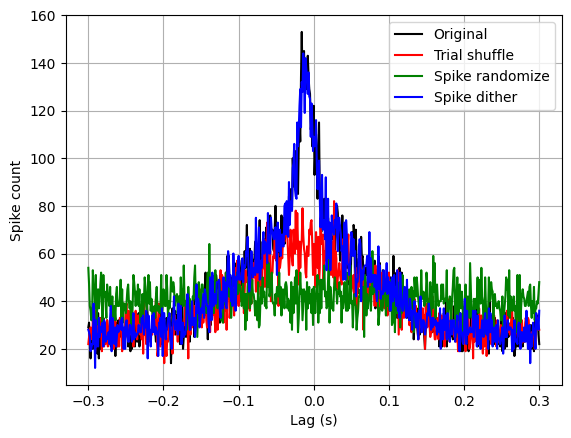

In [21]:
# set appropriate parameter values
t_pre = -0.2
t_post = 0.3
bin_width = 0.001
dither_width = 0.002
lag_max = 0.3

unitIDs = (1, 10)

spikes0 = spikes[unitIDs[0]]
spikes1 = spikes[unitIDs[1]]

# compute the original CCH
cch_orig, lags = correlate_spike_trains(spikes0,spikes1,bin_width,lag_max)    # give appropriate arguments


# generate a trial shuffle surrogate of `spike0`, compute a trial shuffle
# surrogate CHH, and store the result in a variable `cch_TSsrgt`

spikes0_TSsrgt = trial_shuffle(spikes0,stim_on_all,t_pre,t_post)
cch_TSsrgt, lags1 = correlate_spike_trains(spikes0_TSsrgt,spikes1,bin_width,lag_max)

# generate a spike randomize surrogate of `spike0`, compute a spike randomize
# surrogate CHH, and store the result in a variable `cch_SRsrgt`
spikes0_SRsrgt = spike_randomize(spikes0,bin_width)
cch_SRsrgt, lags2 = correlate_spike_trains(spikes0_SRsrgt,spikes1,bin_width,lag_max)

# generate a spike dither surrogate of `spike0`, compute a spike dither
# surrogate CHH, and store the result in a variable `cch_SDsrgt`
spikes0_SDsrgt = spike_dither(spikes0,bin_width, dither_width)
cch_SDsrgt, lags3 = correlate_spike_trains(spikes0_SDsrgt,spikes1,bin_width,lag_max)

# plot the original and surrogate CCHs
plt.plot(lags,cch_orig, 'k-', label="Original")    # give appropriate arguments
plt.plot(lags1,cch_TSsrgt, 'r-', label="Trial shuffle")    # give appropriate arguments
plt.plot(lags2,cch_SRsrgt, 'g-', label="Spike randomize")    # give appropriate arguments
plt.plot(lags3,cch_SDsrgt, 'b-', label="Spike dither")    # give appropriate arguments
plt.grid()
plt.xlabel("Lag (s)")
plt.ylabel("Spike count")
plt.legend()

Now that we have functions to generate surrogate data, we can perform significant tests using surrogate.
As mentioned above, you need to generate a large number of surrogates for a significance test.
The actual number depends on how precisely you want to estimate the p-value.
For instance, if you have 100 surrogates, you can estimate the p-value up to the precision of 1/100 = 0.01 = 1%.
Thus, if you want to perform a significance test with 5% significance level, you need to generate at least 20 surrogates.
In practical cases a much larger number (say, > 1,000) of surrogates would be required.

In the present exercise, for the sake of reasonable computation time, let's use only 20 surrogates.
According to the procedure introduced above, first, you need to generate 20 surrogate data using either of the methods you implemented above, then, you calculate 20 CCHs from the surrogates, and finall, you identify the 95 percentile of the surrogate CCH values.
An easy way to do this is to store the CCHs in a 2-dimensional (rows: surrogates, colums: time lags) array as follows:

    # spikes0, spikes1 : spike trains to be correlated
    cch_buff = []
    for i_srgt in range(20):
        spikes0_srgt = spike_randomize($$$)  # give appropriate arguments
        cch, lags = correlate_spike_trains($$$)    # give appropriate arguments
        cch_buff.append(cch)
    cch_buff = np.array(cch_buff)

and then use a numpy function **numpy.percentile()** as follows:

    cch95p = np.percentile(cch_buff, 95.0, axis=0)

The array cch95p contains the 95th percentile value of the CCH values at each lag.
Note that the argument `axis=0` to `np.percentile()` specifies that the percentile is computed along the first axis of the array `cch_buff`, which means, in our case, along the surrogates for a given lag.

* **Task 4e**: complete the function `find_percentiles()` below. (0.5 point)

In [22]:
def find_percentiles(values, ps):
    """
    find specified percentiles from a population of values

    Arguments
    ---------
    values : an array that contains a population of values from which percentiles are to be found.
        when the array is multi-dimensional, the percentiles are computed along the first dimension.
    ps : a list of percentage values of which percentiles are to be found

    Returns
    -------
    percentiles : a list of percentile values corresponding to the given p-values
    """
    percentiles = []
    for p in ps:
        perc = np.percentile(values, p, axis=0)
        percentiles.append(perc)

    return percentiles

* **Task 4f**: For the three types of surrogate, compute the median (i.e., the 50th percentile) and the 95th percentile of 20 CCHs between surrogate spike trains of units 1 and the original spike train of unit 10, and plot them together with the original CCH. (3 points)

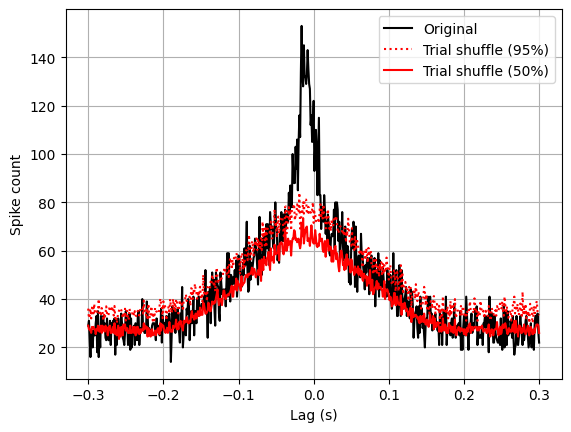

In [23]:

# set appropriate parameter values
t_pre = -0.2
t_post = 0.3
lag_max = 0.3

num_srgt = 20

# compute surrogate CCHs and store them in a buffer array
cch_buff = []
for i in range(num_srgt):

    # generate a trial shuffle surrogate of `spike0`, compute a trial shuffle
    # surrogate CHH, and store the result in a variable `cch_TSsrgt`
    spikes0_TSsrgt = trial_shuffle(spikes0,stim_on_all,t_pre,t_post)
    cch_TSsrgt, lags1 = correlate_spike_trains(spikes0_TSsrgt,spikes1,bin_width,lag_max)
    cch_buff.append(cch_TSsrgt)
cch_buff = np.array(cch_buff)

# find the 95 percentile and the median (i.e 50 percentile) of the surrogate CCH values
cch_srgt95p, cch_srgt50p = find_percentiles(cch_buff,[95.0,50.0])

# plot CCHs
plt.plot(lags,cch_orig,'k-', label="Original")
plt.plot(lags1,cch_srgt95p,'r:', label="Trial shuffle (95%)")
plt.plot(lags1,cch_srgt50p,'r-', label="Trial shuffle (50%)")
plt.grid()
plt.xlabel('Lag (s)')
plt.ylabel('Spike count')
plt.legend()

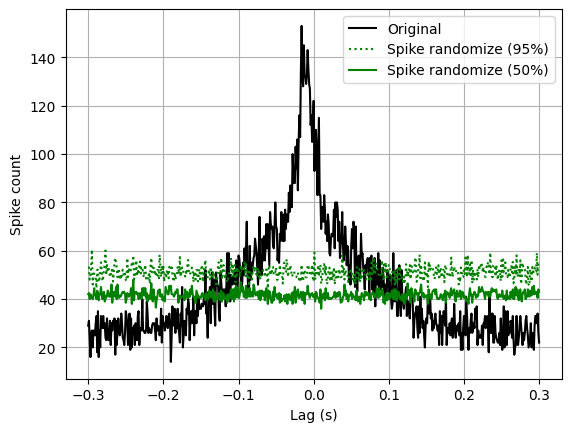

In [29]:
# significance test with spike randomize surrogate

bin_width =0.001
lag_max = 0.3

num_srgt = 20

# compute surrogate CCHs and store them in a buffer array
cch_buff = []
for i in range(num_srgt):

    # generate a spike randomize surrogate of `spike0`, compute a spike randomize
    # surrogate CHH, and store the result in a variable `cch_SRsrgt`
    spikes0_SRsrgt = spike_randomize(spikes0,bin_width)
    cch_SRsrgt, lags2 = correlate_spike_trains(spikes0_SRsrgt,spikes1,bin_width,lag_max)

    cch_buff.append(cch_SRsrgt)
cch_buff = np.array(cch_buff)

# find the 95 percentile and the median (i.e 50 percentile) of the surrogate CCH values
cch_srgt95p, cch_srgt50p = find_percentiles(cch_buff,[95.0,50.0])
# plot CCHs
plt.plot(lags,cch_orig,'k-', label="Original")
plt.plot(lags2,cch_srgt95p, 'g:', label="Spike randomize (95%)")
plt.plot(lags2,cch_srgt50p,  'g-', label="Spike randomize (50%)")
plt.grid()
plt.xlabel('Lag (s)')
plt.ylabel('Spike count')
plt.legend()

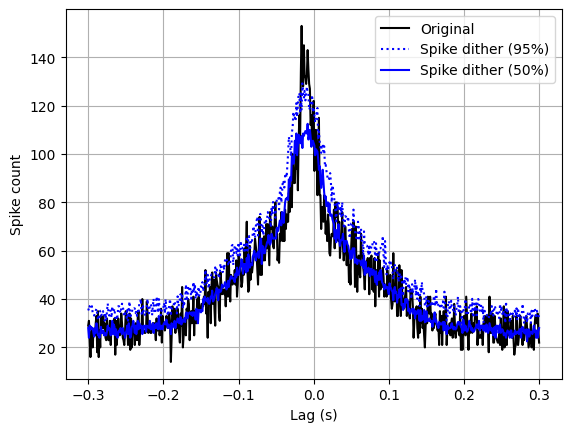

In [30]:
# significance test with spike dither surrogate

# set appropriate parameter values
bin_width = 0.001
dither_width = 0.02
lag_max = 0.3

num_srgt = 20

# compute surrogate CCHs and store them in a buffer array
cch_buff = []
for i in range(num_srgt):

    # generate a spike dither surrogate of `spike0`, compute a spike dither
    # surrogate CHH, and store the result in a variable `cch_SDsrgt`
    spikes0_SDsrgt = spike_dither(spikes0,bin_width, dither_width)
    cch_SDsrgt, lags3 = correlate_spike_trains(spikes0_SDsrgt,spikes1,bin_width,lag_max)

    cch_buff.append(cch_SDsrgt)
cch_buff = np.array(cch_buff)

# find the 95 percentile and the median (i.e 50 percentile) of the surrogate CCH values
cch_srgt95p, cch_srgt50p = find_percentiles(cch_buff,[95.0,50.0])

# plot CCHs
plt.plot(lags,cch_orig,'k-', label="Original")
plt.plot(lags3,cch_srgt95p,  'b:', label="Spike dither (95%)")    # give appropriate arguments
plt.plot(lags3,cch_srgt50p,'b-', label="Spike dither (50%)")    # give appropriate arguments
plt.grid()
plt.xlabel('Lag (s)')
plt.ylabel('Spike count')
plt.legend()